In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.linalg import norm
import sklearn.datasets as skds
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import robust_scale
from sklearn import datasets
import torch
from optimization import Friedman,LinearRegression, train_model

In [2]:
def save_data(n_sim,n_epochs,noise):
    file = '../results/friedman_sim_data_'+'obs_'+str(n_sim)+'sims_'+str(n_epochs)+'_epochs_noise'+str(noise)+'.npz'
    np.savez(file,beta_mse = beta_mse,elapsed_time = elapsed_time,loss_history = loss_history)
    
def load_data(fname):
    data = np.load(fname,allow_pickle = True)
    return data['beta_mse'],data['elapsed_time'],data['loss_history']

## Noise = 0

In [3]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
b = np.array([10,20,0.5,10,5]) # DO NOT CHANGE, THESE ARE TRUE BETAS 
n_epochs = 250
n_sim = 100
noise = 0

In [ ]:
# Skip to next cell if re-running
# Track loss, beta error, and elapsed time
loss_history = {
    'newton': np.zeros((n_sim, n_epochs)),
    'sgd': np.zeros((n_sim, n_epochs)),
    'lbfgs': np.zeros((n_sim, n_epochs))
}

beta_mse = {
    'newton': np.zeros(n_sim),
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}

elapsed_time = {
    'newton': np.zeros(n_sim),
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}



for i in tqdm(range(n_sim)): # 100 simulations take 6 minutes
    X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=noise, random_state=i)
    X_new = torch.tensor(X,requires_grad=True)
    y_new = torch.tensor(y,requires_grad=True)
    
    b_hat_newton, loss_hist_newton, elapsed_newton = train_model(X_new, y_new,model = Friedman, method='newton', n_epochs=n_epochs)
    b_hat_sgd, loss_hist_sgd, elapsed_sgd = train_model(X_new, y_new,model = Friedman, method='sgd', n_epochs=n_epochs)
    b_hat_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = train_model(X_new, y_new,model = Friedman, method='lbfgs', n_epochs=n_epochs)
    
    beta_mse['newton'][i] = float(((b - np.array(b_hat_newton))**2).mean())
    elapsed_time['newton'][i] = elapsed_newton
    loss_history['newton'][i] = loss_hist_newton

    beta_mse['sgd'][i] = float(((b - np.array(b_hat_sgd))**2).mean())
    elapsed_time['sgd'][i] = elapsed_sgd
    loss_history['sgd'][i] = loss_hist_sgd
    
    beta_mse['lbfgs'][i] = float(((b - np.array(b_hat_lbfgs))**2).mean())
    elapsed_time['lbfgs'][i] = elapsed_lbfgs
    loss_history['lbfgs'][i] = loss_hist_lbfgs
save_data(n_sim,n_epochs,noise)

In [4]:
# Load from save .npz files
fname_0noise = '../results/friedman_sim_data_obs_100sims_250_epochs_noise0.npz'

beta_mse_0noise, elapsed_time_0noise, loss_history_0noise = load_data(fname_0noise)
beta_mse_0noise = beta_mse_0noise.flatten()[0]
elapsed_time_0noise = elapsed_time_0noise.flatten()[0]
loss_history_0noise = loss_history_0noise.flatten()[0]

Text(0, 0.5, 'Time (s)')

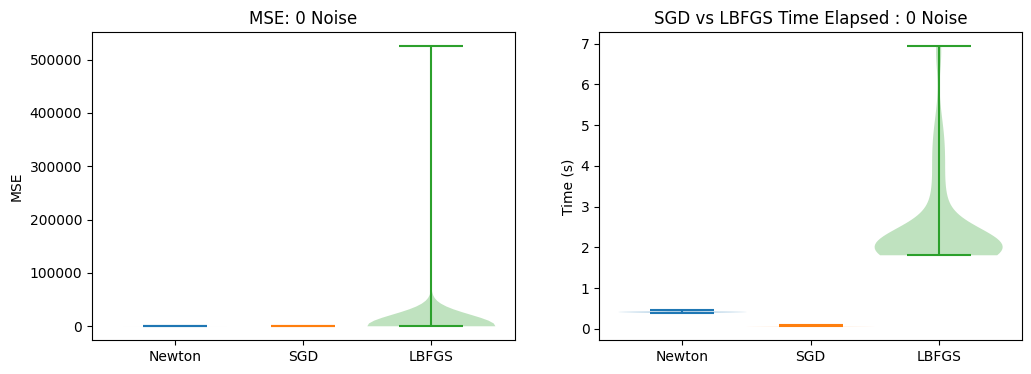

In [5]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])
    
axes[0].violinplot(get_finite_vals(beta_mse_0noise['newton']), positions = [1])
axes[0].violinplot(get_finite_vals(beta_mse_0noise['sgd']), positions=[1.5])
axes[0].violinplot(get_finite_vals(beta_mse_0noise['lbfgs']), positions=[2])
    
axes[1].violinplot(elapsed_time_0noise['newton'])
axes[1].violinplot(elapsed_time_0noise['sgd'], positions=[1.5])
axes[1].violinplot(get_finite_vals(elapsed_time_0noise['lbfgs']), positions=[2])
    
axes[0].set_xticks([1, 1.5,2], ['Newton','SGD', 'LBFGS'])
axes[1].set_xticks([1, 1.5,2], ['Newton','SGD', 'LBFGS'])
    
axes[0].set_title(f'MSE: '+str(noise) +' Noise')
axes[1].set_title(f'SGD vs LBFGS Time Elapsed : '+str(noise) +' Noise')
    
axes[0].set_ylabel('MSE')
axes[1].set_ylabel('Time (s)')

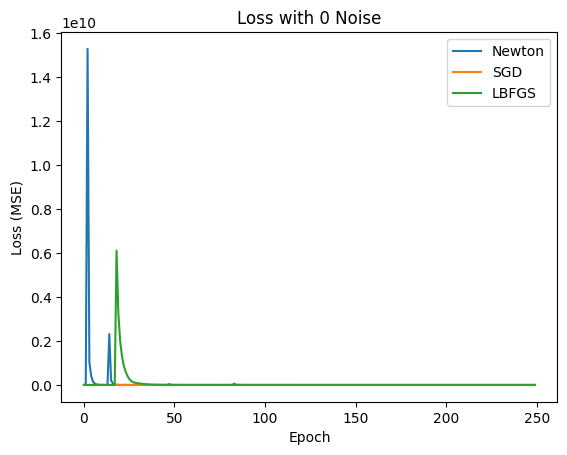

In [6]:
plt.figure(0)
plt.title(f'Loss with ' + str(noise) +  ' Noise')
plt.plot(np.nanmean(loss_history_0noise['newton'],axis = 0), label='Newton')
plt.plot(np.nanmean(loss_history_0noise['sgd'],axis = 0), label='SGD')
plt.plot(np.nanmean(loss_history_0noise['lbfgs'],axis = 0 ), label='LBFGS')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

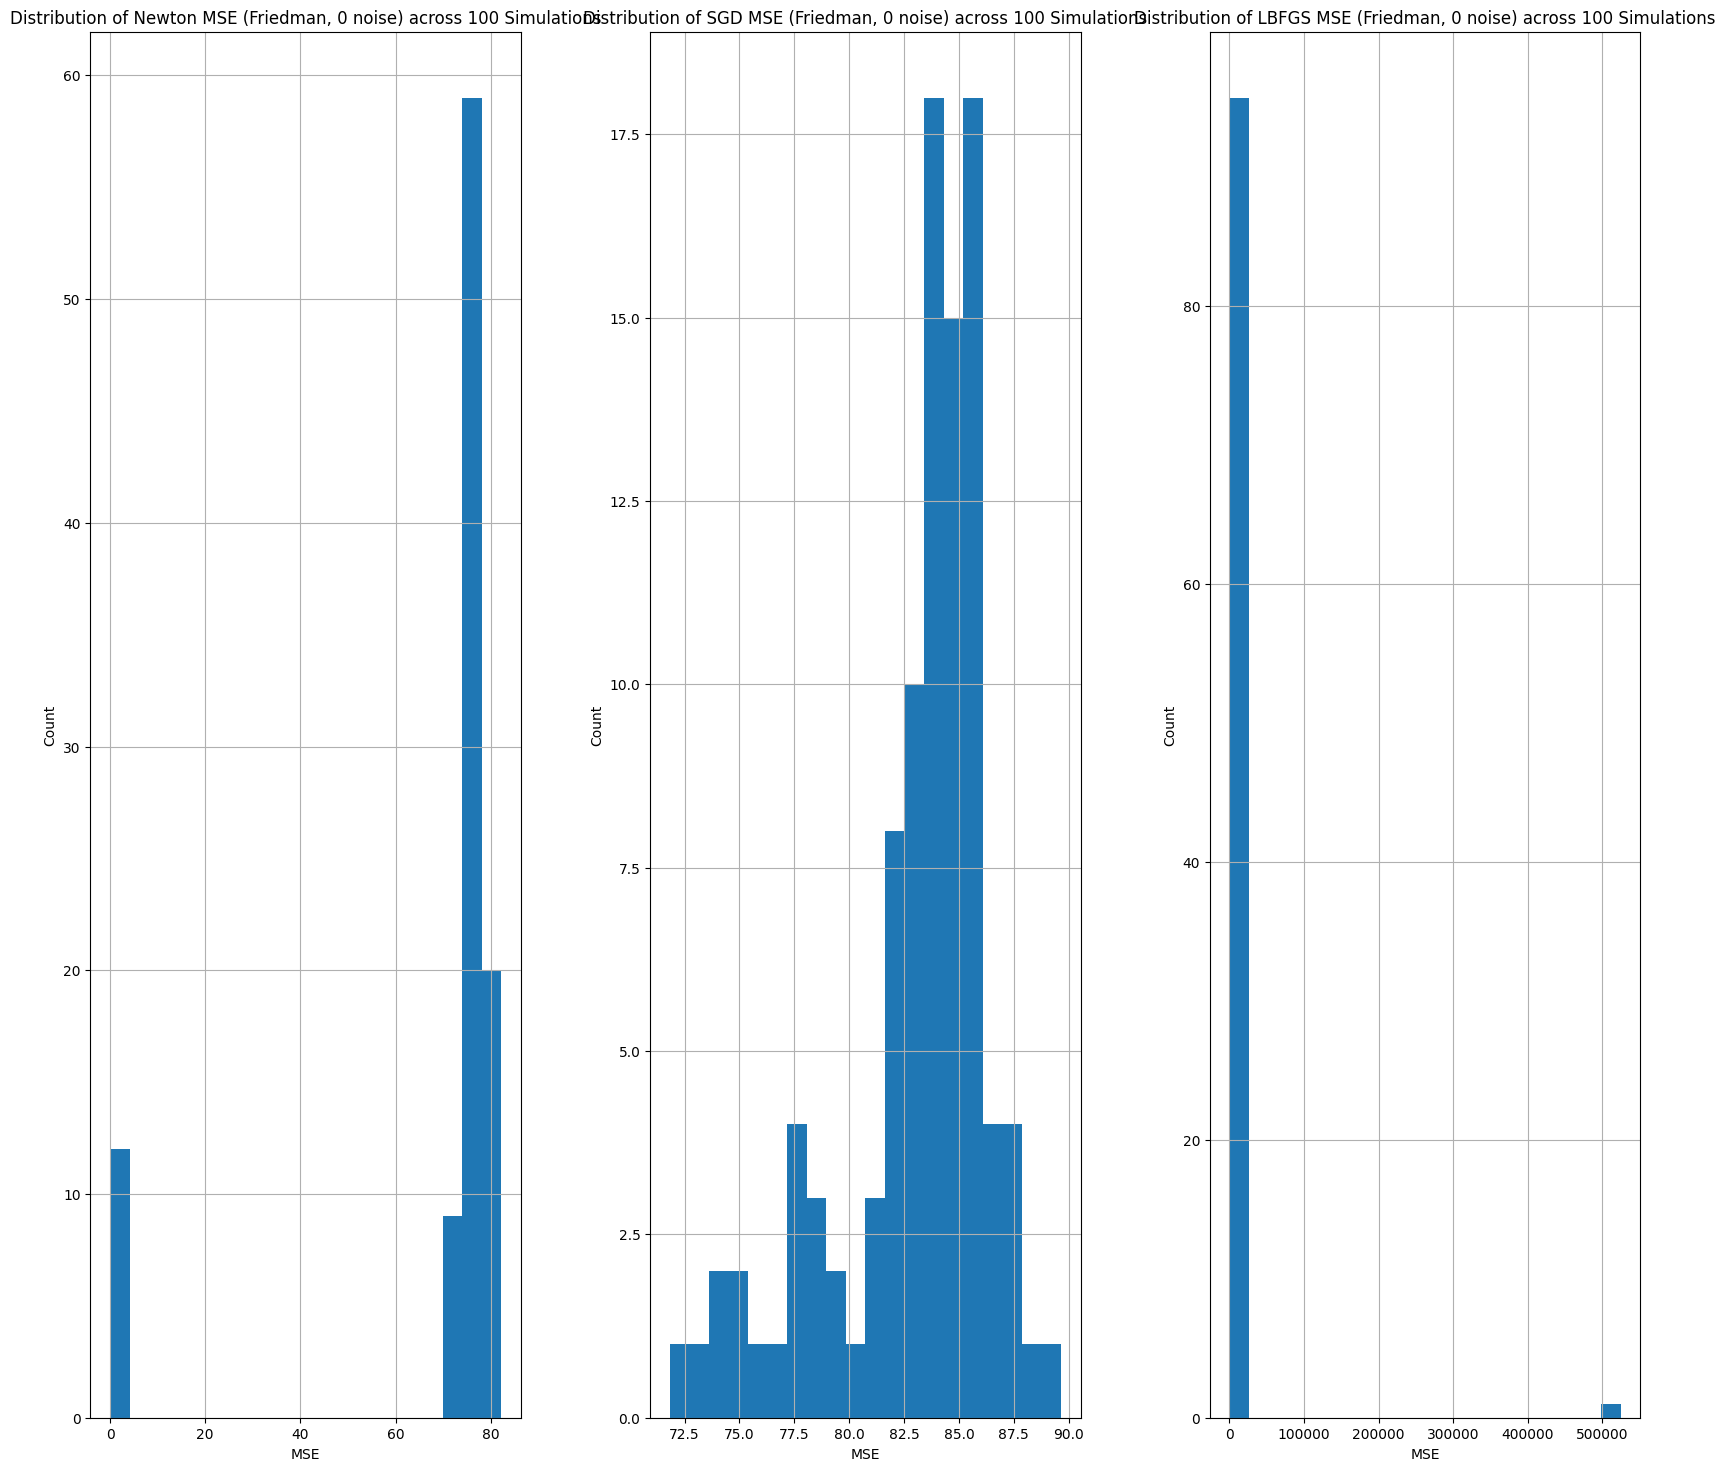

In [7]:
newton_mse_df = pd.DataFrame(beta_mse_0noise['newton'])
sgd_mse_df = pd.DataFrame(beta_mse_0noise['sgd'])
lbfgs_mse_df = pd.DataFrame(beta_mse_0noise['lbfgs'])

fig, ax = plt.subplots(1, 3, figsize=(20, 18))

newton_mse_df.hist(ax = ax[0],bins = 20)
ax[0].set_title('Distribution of Newton MSE (Friedman, 0 noise) across 100 Simulations')
ax[0].set_xlabel('MSE')
ax[0].set_ylabel('Count')

sgd_mse_df.hist(ax = ax[1],bins = 20)
ax[1].set_title('Distribution of SGD MSE (Friedman, 0 noise) across 100 Simulations')
ax[1].set_xlabel('MSE')
ax[1].set_ylabel('Count')

lbfgs_mse_df.hist(ax = ax[2], bins = 20)
ax[2].set_title('Distribution of LBFGS MSE (Friedman, 0 noise) across 100 Simulations')
ax[2].set_xlabel('MSE')
ax[2].set_ylabel('Count')


five_num_summary_mse = pd.concat([newton_mse_df.describe(),sgd_mse_df.describe(),lbfgs_mse_df.describe()],axis = 1)
five_num_summary_mse.columns = ['Newton','SGD','LBFGS']
fname = '../results/friedman_sim_data_'+str(n_sim)+'sims_'+str(n_epochs)+'epochs_'+str(noise)+'noise_mse5summ.xlsx'
five_num_summary_mse.to_csv(fname)

## Noise = 50

In [8]:
b = np.array([10,20,0.5,10,5]) # DO NOT CHANGE, THESE ARE TRUE BETAS 
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
n_epochs = 250
n_sim = 100
noise = 50

In [ ]:
# Skip to next cell if re-running
# Track loss, beta error, and elapsed time
loss_history = {
    'newton': np.zeros((n_sim, n_epochs)),
    'sgd': np.zeros((n_sim, n_epochs)),
    'lbfgs': np.zeros((n_sim, n_epochs))
}

beta_mse = {
    'newton': np.zeros(n_sim),
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}

elapsed_time = {
    'newton': np.zeros(n_sim),
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}



for i in tqdm(range(n_sim)): # 100 simulations take 6 minutes
    X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=noise, random_state=i)
    X_new = torch.tensor(X,requires_grad=True)
    y_new = torch.tensor(y,requires_grad=True)
    
    b_hat_newton, loss_hist_newton, elapsed_newton = train_model(X_new, y_new,model = Friedman, method='newton', n_epochs=n_epochs)
    b_hat_sgd, loss_hist_sgd, elapsed_sgd = train_model(X_new, y_new,model = Friedman, method='sgd', n_epochs=n_epochs)
    b_hat_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = train_model(X_new, y_new,model = Friedman, method='lbfgs', n_epochs=n_epochs)
    
    beta_mse['newton'][i] = float(((b - np.array(b_hat_newton))**2).mean())
    elapsed_time['newton'][i] = elapsed_newton
    loss_history['newton'][i] = loss_hist_newton

    beta_mse['sgd'][i] = float(((b - np.array(b_hat_sgd))**2).mean())
    elapsed_time['sgd'][i] = elapsed_sgd
    loss_history['sgd'][i] = loss_hist_sgd
    
    beta_mse['lbfgs'][i] = float(((b - np.array(b_hat_lbfgs))**2).mean())
    elapsed_time['lbfgs'][i] = elapsed_lbfgs
    loss_history['lbfgs'][i] = loss_hist_lbfgs
    
save_data(n_sim,n_epochs,noise)

In [9]:
# Load from save .npz files
fname_50noise = '../results/friedman_sim_data_obs_100sims_250_epochs_noise50.npz'

beta_mse_50noise, elapsed_time_50noise, loss_history_50noise = load_data(fname_50noise)
beta_mse_50noise = beta_mse_50noise.flatten()[0]
elapsed_time_50noise = elapsed_time_50noise.flatten()[0]
loss_history_50noise = loss_history_50noise.flatten()[0]

Text(0, 0.5, 'Time (s)')

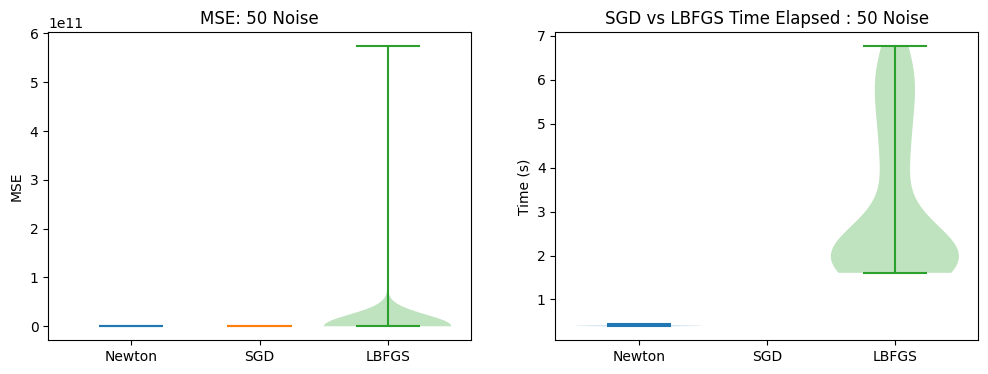

In [10]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])
    
axes[0].violinplot(get_finite_vals(beta_mse_50noise['newton']), positions = [1])
axes[0].violinplot(get_finite_vals(beta_mse_50noise['sgd']), positions=[1.5])
axes[0].violinplot(get_finite_vals(beta_mse_50noise['lbfgs']), positions=[2])
    
axes[1].violinplot(elapsed_time_50noise['newton'])
axes[1].violinplot(elapsed_time_50noise['sgd'], positions=[1.5])
axes[1].violinplot(get_finite_vals(elapsed_time_50noise['lbfgs']), positions=[2])
    
axes[0].set_xticks([1, 1.5,2], ['Newton','SGD', 'LBFGS'])
axes[1].set_xticks([1, 1.5,2], ['Newton','SGD', 'LBFGS'])
    
axes[0].set_title(f'MSE: '+str(noise) +' Noise')
axes[1].set_title(f'SGD vs LBFGS Time Elapsed : '+str(noise) +' Noise')
    
axes[0].set_ylabel('MSE')
axes[1].set_ylabel('Time (s)')

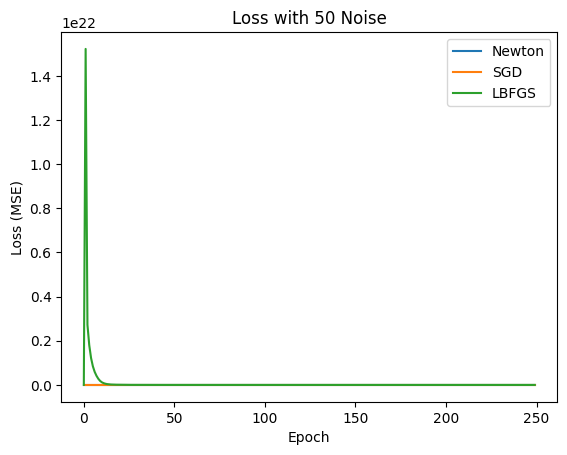

In [11]:
plt.figure(0)
plt.title(f'Loss with ' + str(noise) +  ' Noise')
plt.plot(np.nanmean(loss_history_50noise['newton'],axis = 0), label='Newton')
plt.plot(np.nanmean(loss_history_50noise['sgd'],axis = 0), label='SGD')
plt.plot(np.nanmean(loss_history_50noise['lbfgs'],axis = 0 ), label='LBFGS')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

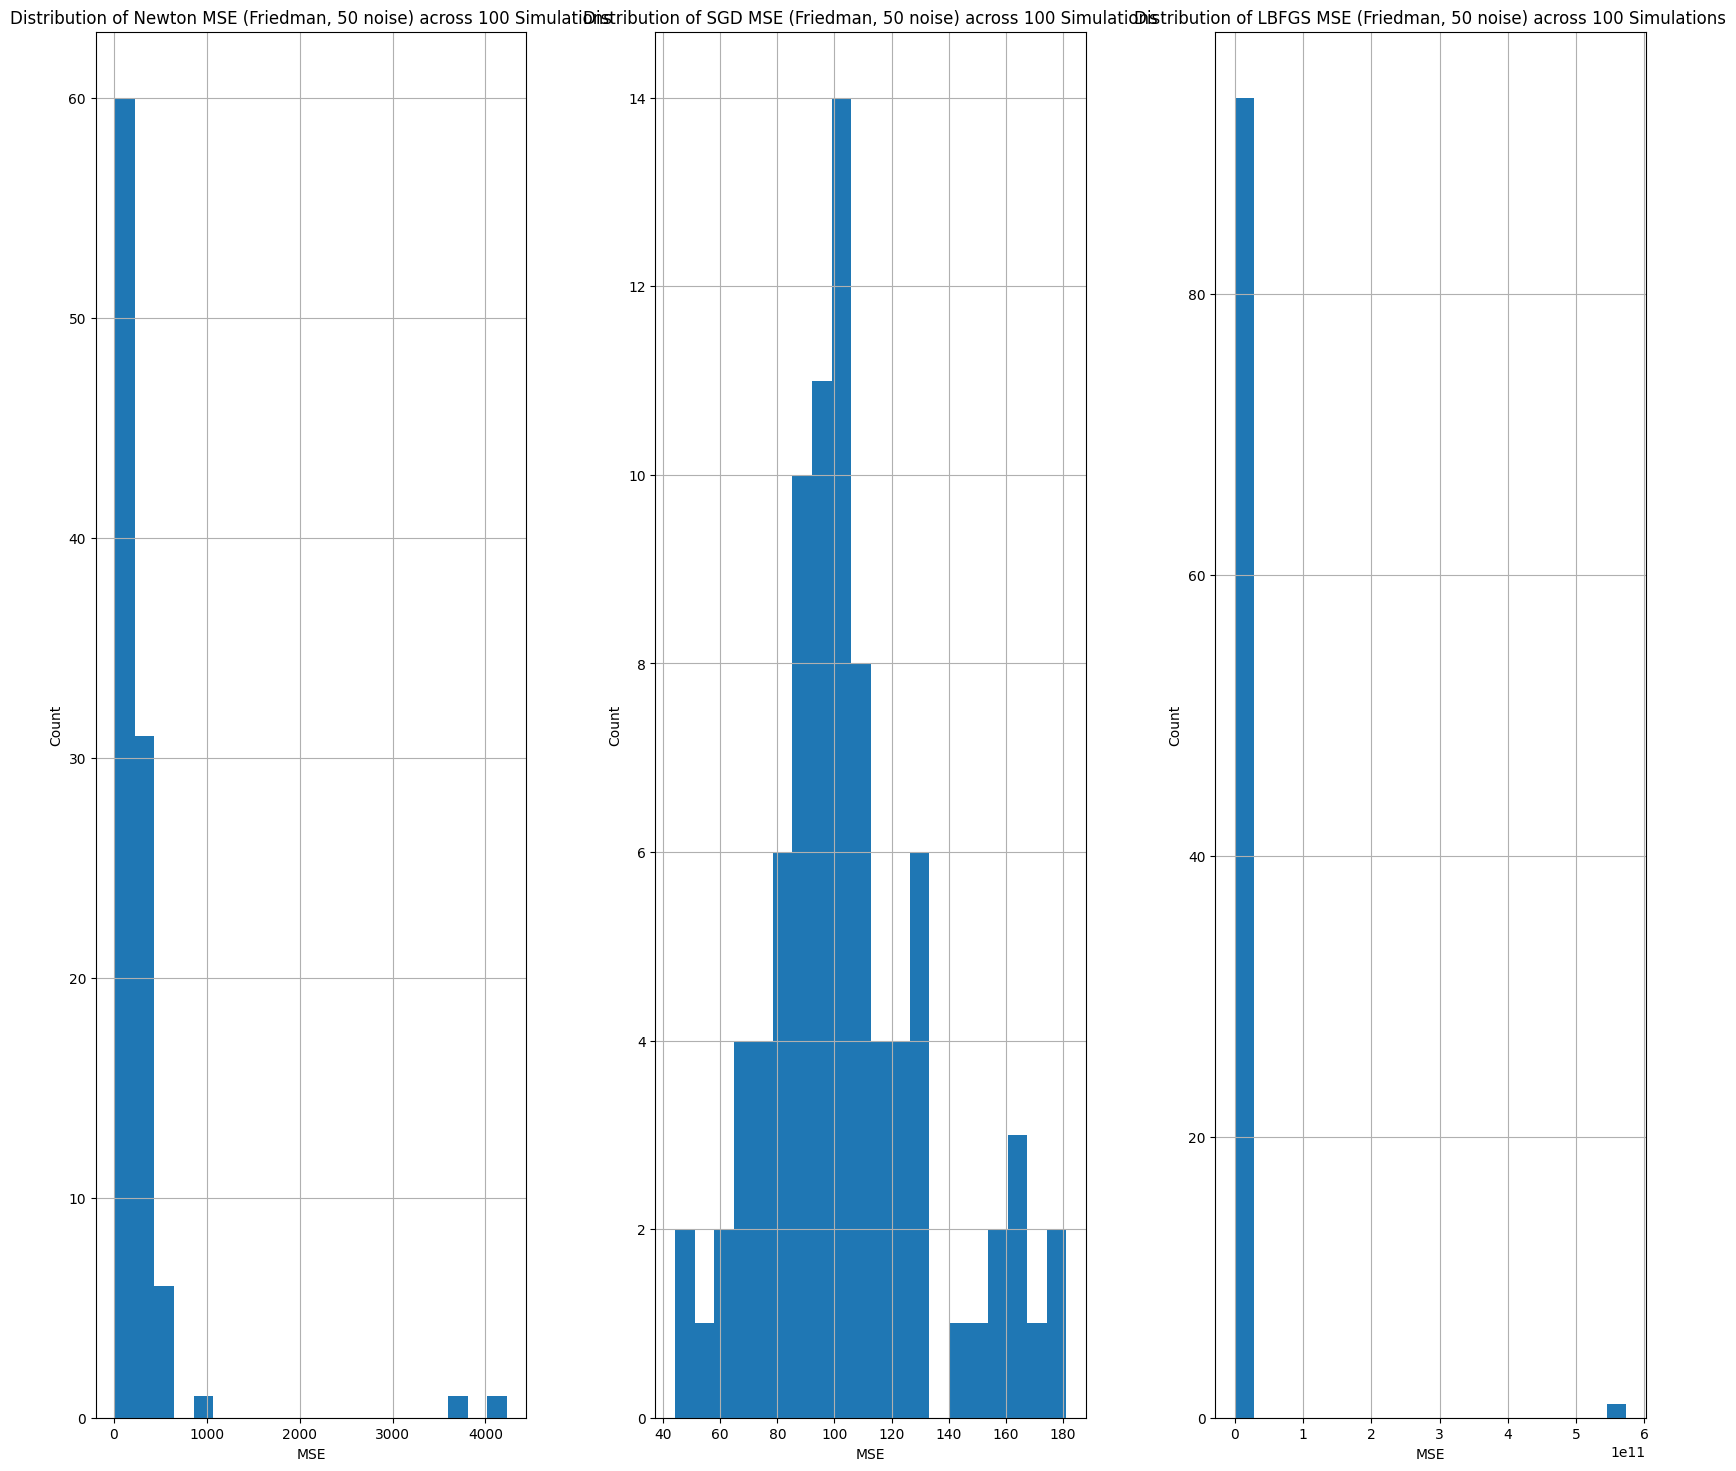

In [12]:
# Skip to next cell if re-running
newton_mse_df = pd.DataFrame(beta_mse_50noise['newton'])
sgd_mse_df = pd.DataFrame(beta_mse_50noise['sgd'])
lbfgs_mse_df = pd.DataFrame(beta_mse_50noise['lbfgs'])

fig, ax = plt.subplots(1, 3, figsize=(20, 18))

newton_mse_df.hist(ax = ax[0],bins = 20)
ax[0].set_title('Distribution of Newton MSE (Friedman, 50 noise) across 100 Simulations')
ax[0].set_xlabel('MSE')
ax[0].set_ylabel('Count')

sgd_mse_df.hist(ax = ax[1],bins = 20)
ax[1].set_title('Distribution of SGD MSE (Friedman, 50 noise) across 100 Simulations')
ax[1].set_xlabel('MSE')
ax[1].set_ylabel('Count')

lbfgs_mse_df.hist(ax = ax[2], bins = 20)
ax[2].set_title('Distribution of LBFGS MSE (Friedman, 50 noise) across 100 Simulations')
ax[2].set_xlabel('MSE')
ax[2].set_ylabel('Count')


five_num_summary_mse = pd.concat([newton_mse_df.describe(),sgd_mse_df.describe(),lbfgs_mse_df.describe()],axis = 1)
five_num_summary_mse.columns = ['Newton','SGD','LBFGS']
fname = '../results/friedman_sim_data_'+str(n_sim)+'sims_'+str(n_epochs)+'epochs_'+str(noise)+'noise_mse5summ.xlsx'
five_num_summary_mse.to_csv(fname)

## 100 noise

In [13]:
b = np.array([10,20,0.5,10,5]) # DO NOT CHANGE, THESE ARE TRUE BETAS 
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
n_epochs = 250
n_sim = 100
noise = 100

In [ ]:
# Skip to next cell if re-running
# Track loss, beta error, and elapsed time
loss_history = {
    'newton': np.zeros((n_sim, n_epochs)),
    'sgd': np.zeros((n_sim, n_epochs)),
    'lbfgs': np.zeros((n_sim, n_epochs))
}

beta_mse = {
    'newton': np.zeros(n_sim),
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}

elapsed_time = {
    'newton': np.zeros(n_sim),
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}



for i in tqdm(range(n_sim)): # 100 simulations take 6 minutes
    X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=noise, random_state=i)
    X_new = torch.tensor(X,requires_grad=True)
    y_new = torch.tensor(y,requires_grad=True)
    
    b_hat_newton, loss_hist_newton, elapsed_newton = train_model(X_new, y_new,model = Friedman, method='newton', n_epochs=n_epochs)
    b_hat_sgd, loss_hist_sgd, elapsed_sgd = train_model(X_new, y_new,model = Friedman, method='sgd', n_epochs=n_epochs)
    b_hat_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = train_model(X_new, y_new,model = Friedman, method='lbfgs', n_epochs=n_epochs)
    
    beta_mse['newton'][i] = float(((b - np.array(b_hat_newton))**2).mean())
    elapsed_time['newton'][i] = elapsed_newton
    loss_history['newton'][i] = loss_hist_newton

    beta_mse['sgd'][i] = float(((b - np.array(b_hat_sgd))**2).mean())
    elapsed_time['sgd'][i] = elapsed_sgd
    loss_history['sgd'][i] = loss_hist_sgd
    
    beta_mse['lbfgs'][i] = float(((b - np.array(b_hat_lbfgs))**2).mean())
    elapsed_time['lbfgs'[]i] = elapsed_lbfgs
    loss_history['lbfgs'][i] = loss_hist_lbfgs
save_data(n_sim,n_epochs,noise)

In [14]:
# Load from save .npz files
fname_100noise = '../results/friedman_sim_data_obs_100sims_250_epochs_noise100.npz'

beta_mse_100noise, elapsed_time_100noise, loss_history_100noise = load_data(fname_100noise)
beta_mse_100noise = beta_mse_100noise.flatten()[0]
elapsed_time_100noise = elapsed_time_100noise.flatten()[0]
loss_history_100noise = loss_history_100noise.flatten()[0]

Text(0, 0.5, 'Time (s)')

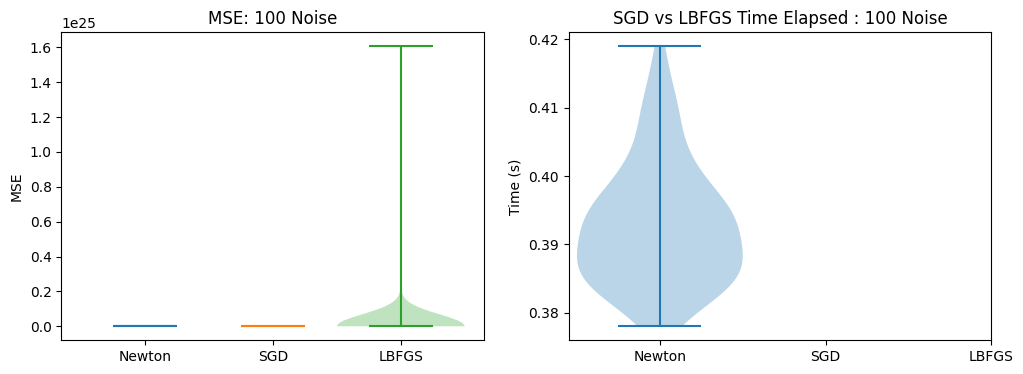

In [15]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])
    
axes[0].violinplot(get_finite_vals(beta_mse_100noise['newton']), positions = [1])
axes[0].violinplot(get_finite_vals(beta_mse_100noise['sgd']), positions=[1.5])
axes[0].violinplot(get_finite_vals(beta_mse_100noise['lbfgs']), positions=[2])
    
axes[1].violinplot(elapsed_time_100noise['newton'])
axes[1].violinplot(elapsed_time_100noise['sgd'], positions=[1.5])
axes[1].violinplot(elapsed_time_100noise['lbfgs'], positions=[2])
    
axes[0].set_xticks([1, 1.5,2], ['Newton','SGD', 'LBFGS'])
axes[1].set_xticks([1, 1.5,2], ['Newton','SGD', 'LBFGS'])
    
axes[0].set_title(f'MSE: '+str(noise) +' Noise')
axes[1].set_title(f'SGD vs LBFGS Time Elapsed : '+str(noise) +' Noise')
    
axes[0].set_ylabel('MSE')
axes[1].set_ylabel('Time (s)')

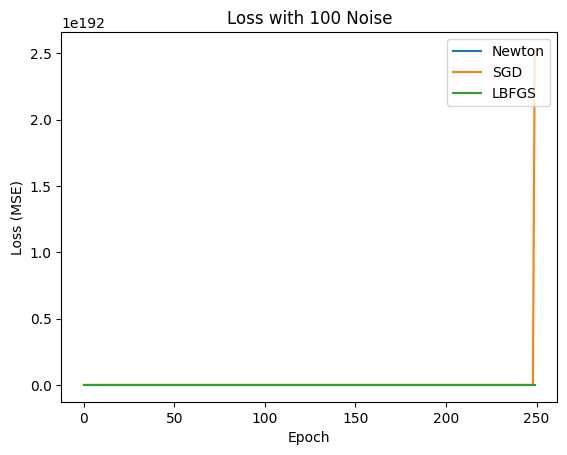

In [16]:
plt.figure(0)
plt.title(f'Loss with ' + str(noise) +  ' Noise')
plt.plot(np.nanmean(loss_history_100noise['newton'],axis = 0), label='Newton')
plt.plot(np.nanmean(loss_history_100noise['sgd'],axis = 0), label='SGD')
plt.plot(np.nanmean(loss_history_100noise['lbfgs'],axis = 0), label='LBFGS')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

In [17]:
newton_mse_df = pd.DataFrame(beta_mse_100noise['newton'])
sgd_mse_df = pd.DataFrame(beta_mse_100noise['sgd'])
lbfgs_mse_df = pd.DataFrame(beta_mse_100noise['lbfgs'])

#fig, ax = plt.subplots(1, 3, figsize=(20, 18))

#newton_mse_df.hist(ax = ax[0],bins = 20)
#ax[0].set_title('Distribution of Newton MSE (Friedman, 50 noise) across 100 Simulations')
#ax[0].set_xlabel('MSE')
#ax[0].set_ylabel('Count')

#sgd_mse_df.hist(ax = ax[1],bins = 20)
#ax[1].set_title('Distribution of SGD MSE (Friedman, 50 noise) across 100 Simulations')
#ax[1].set_xlabel('MSE')
#ax[1].set_ylabel('Count')

#bfgs_mse_df.hist(ax = ax[2], bins = 20)
#ax[2].set_title('Distribution of LBFGS MSE (Friedman, 50 noise) across 100 Simulations')
#ax[2].set_xlabel('MSE')
#ax[2].set_ylabel('Count')

five_num_summary_mse = pd.concat([newton_mse_df.describe(),sgd_mse_df.describe(),lbfgs_mse_df.describe()],axis = 1)
five_num_summary_mse.columns = ['Newton','SGD','LBFGS']
fname = '../results/friedman_sim_data_'+str(n_sim)+'sims_'+str(n_epochs)+'epochs_'+str(noise)+'noise_mse5summ.xlsx'
five_num_summary_mse.to_csv(fname)

The suprising thing here is that with hand calculations, you will get the wrong result. The LGBFS model is able to perform even with the noise and get the true $\beta$. The SGD algorithm is not able to discern it.

In [18]:
X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=100, random_state=1)
X_new = torch.tensor(X,requires_grad=True)
y_new = torch.tensor(y,requires_grad=True)

## Sanity Check

In [19]:
X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=0, random_state=1)
X_new = torch.tensor(X,requires_grad=True)
y_new = torch.tensor(y,requires_grad=True)

With 0 noise, it matches.

In [21]:
y_hat = b[0]*torch.sin(torch.pi*X_new[:,0]*X_new[:,1]) + b[1]*(X_new[:,2]-b[2])**2 + (b[3]*(X_new[:,3])) + (b[4]* X_new[:,4])
assert(torch.equal(y_hat,y_new))